In [25]:
import pandas as pd
import numpy as np
import time
import copy
import datetime
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.naive_bayes import GaussianNB

In [59]:
course_id = 'KNU/101/2014_T2'
user_id = 50444
sm = pd.read_csv('data\courseware_studentmodule.csv')

In [60]:
users = pd.read_csv('data\users.csv')

In [61]:
cert = pd.read_csv('data\certificates_generatedcertificate.csv')

In [76]:
related_columns = sm[(sm.module_type == 'problem') & (sm.course_id == course_id)].module_id.unique()

In [63]:
sm = sm[sm.module_type == 'problem']
sm = sm.rename(columns = {'student_id':'user_id'})
sm.grade = map(lambda x: x if x != '\\b' else 0,sm.grade.tolist())
cert = cert[cert.course_id == course_id]
registered = cert.user_id.unique()
users = users[users.id.isin(registered)]

In [64]:
#fit
##__getProblemResultFeatures
start_time = time.time()
modules = sm.module_id.unique().tolist()
result = []
for module in modules:
    first = sm[sm.module_id == module].created.min()
    result.append({'name':module,'date':first})
labels = map(lambda x: x['name'],sorted(result,key=lambda x: x['date']))
rebased = sm.pivot(index='user_id',columns='module_id',values='grade')
rebased = rebased[labels].fillna(0)
res_features =  rebased
print '__getProblemResultFeatures finished in ' + str(time.time() - start_time)
##

__getProblemResultFeatures finished in 89.3380000591


In [66]:
##__getUserDataFeatures
start_time = time.time()
u = pd.DataFrame(users[['gender','year_of_birth','level_of_education']],index=users.user_id)
c = cert.set_index(cert.user_id)[['grade','status']]
c['status'] = c.apply(lambda x: 1 if x.status == 'downloadable' else 0,1)
u_features = c.join(u)
print '__getUserDataFeatures finished in ' + str(time.time() - start_time)
##

__getUserDataFeatures finished in 0.676000118256


In [67]:
len(res_features)

53013

In [68]:
##__lastPassedTest
start_time = time.time()
features = res_features.ix[user_id].tolist()
index = len(features)
for i in reversed(features):
    if i != 0:
        break
    index -= 1
if index == 0:
    index = len(res_features.columns)
last = index
print '__lastPassedTest finished in ' + str(time.time() - start_time)
##

__lastPassedTest finished in 0.00600004196167


In [69]:
start_time = time.time()
cols = res_features.columns[:last].tolist()
dataset = u_features.join(res_features)
data = dataset[cols].fillna(0)
Y = dataset.status
print '_final preparations finished in ' + str(time.time() - start_time)

_final preparations finished in 3.64800000191


In [70]:
model = GaussianNB()
start_time = time.time()
predicted = cross_val_predict(model, data, Y)
print 'cross_val_predict finished in ' + str(time.time() - start_time)

score = float(np.sum(predicted == Y))/len(data)
start_time = time.time()
model.fit(data,Y)
print 'fit finished in ' + str(time.time() - start_time)

cross_val_predict finished in 4.67900013924
fit finished in 1.35299992561


In [71]:
#predict

cols = res_features.columns.tolist()[:last]
start_time = time.time()
answer = model.predict(res_features[cols].ix[user_id].tolist())
print 'predict finished in ' + str(time.time() - start_time)
print score

predict finished in 0.570999860764
0.607830299856


C:\Users\mberezhnyak\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [58]:
#fit
##__getProblemResultFeatures
start_time = time.time()
modules = sm[sm.course_id == course_id].module_id.unique().tolist()
result = []
for module in modules:
    first = sm[sm.module_id == module].created.min()
    result.append({'name':module,'date':first})
labels = map(lambda x: x['name'],sorted(result,key=lambda x: x['date']))
rebased = sm.pivot(index='user_id',columns='module_id',values='grade')
rebased = rebased[labels].fillna(0)
res_features =  rebased
print '__getProblemResultFeatures finished in ' + str(time.time() - start_time)
##
##__getUserDataFeatures
start_time = time.time()
u = pd.DataFrame(users[['gender','year_of_birth','level_of_education']],index=users.user_id)
c = cert.set_index(cert.user_id)[['grade','status']]
c['status'] = c.apply(lambda x: 1 if x.status == 'downloadable' else 0,1)
u_features = c.join(u)
print '__getUserDataFeatures finished in ' + str(time.time() - start_time)
##
##__lastPassedTest
start_time = time.time()
features = res_features.ix[user_id].tolist()
index = len(features)
for i in reversed(features):
    if i != 0:
        break
    index -= 1
if index == 0:
    index = len(res_features.columns)
last = index
print '__lastPassedTest finished in ' + str(time.time() - start_time)
#############
start_time = time.time()
cols = res_features.columns[:last].tolist()
dataset = u_features.join(res_features)
data = dataset[cols].fillna(0)
Y = dataset.status
print '_final preparations finished in ' + str(time.time() - start_time)
##############

input = dataset.fillna(0)
output = dataset.status

#prediction test
model = GaussianNB()
start_time = time.time()
predicted = cross_val_predict(model, data, Y)
print 'cross_val_predict finished in ' + str(time.time() - start_time)

score = float(np.sum(predicted == Y))/len(data)
start_time = time.time()
model.fit(data,Y)
print 'score is {0}'.format(score)
print 'fit finished in ' + str(time.time() - start_time)

cols = res_features.columns.tolist()[:last]
start_time = time.time()
answer = model.predict(res_features[cols].ix[user_id].tolist())
print 'predict finished in ' + str(time.time() - start_time)

__getProblemResultFeatures finished in 6.3029999733
__getUserDataFeatures finished in 0.763999938965
__lastPassedTest finished in 0.00499987602234
_final preparations finished in 0.0540001392365
cross_val_predict finished in 0.0899999141693
score is 0.992078041116
fit finished in 0.0230000019073
predict finished in 0.00600004196167


C:\Users\mberezhnyak\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [72]:
ex_cols = list(cols)
ex_cols.append('status')
print ex_cols[-1]
print ex_cols[-2]

status
i4x://Prometheus/103/problem/e09fe3fb88334075b272a202f08694f8


In [73]:
dataset_x = dataset.fillna(0)[ex_cols]

baseFrame = pd.DataFrame(dataset_x.values.astype(float), columns=dataset_x.columns, index=map(lambda x: str(x) + '_x0' ,dataset_x.index.tolist()))
#for i in range(1,5):
#    currentFrame = pd.DataFrame(dataset_x.values.astype(float), columns=dataset_x.columns, index=map(lambda x: str(x) + '_x' + str(i) ,dataset_x.index.tolist()))
#    baseFrame = pd.concat([baseFrame, currentFrame])

In [74]:
print len(cols)
print len(baseFrame.columns)
print len(baseFrame)

1076
1077
15274


In [19]:
input = baseFrame[cols]
output = baseFrame.status

#prediction test
model = GaussianNB()
start_time = time.time()
predicted = cross_val_predict(model, input, output)
print 'cross_val_predict finished in ' + str(time.time() - start_time)

score = float(np.sum(predicted == output))/len(input)
start_time = time.time()
model.fit(input,output)
print 'fit finished in ' + str(time.time() - start_time)

cols = res_features.columns.tolist()[:last]
start_time = time.time()
answer = model.predict(res_features[cols].ix[user_id].tolist())
print 'predict finished in ' + str(time.time() - start_time)

cross_val_predict finished in 11.6229999065
fit finished in 3.16700005531
predict finished in 0.612999916077


In [21]:
dataset_x.to_csv('data\dummy\dataset_x.csv')

In [25]:
a = pd.DataFrame([[1,1,1],[1,1,1]], columns=['one','two','three'])
a

,one,two,three
0,1,1,1
1,1,1,1


In [26]:
#a.to_csv('a.csv',index=False)
#b = pd.DataFrame([[2,2,2],[2,2,2]], columns=['one','two','three'])
#with open('a.csv', 'a') as f:
#    b.to_csv(f, header=False,index=False)

In [108]:
related_columns_with_status = list(related_columns)
related_columns_with_status.append('status')
related_columns_with_status
dataset_reduced = dataset_x[related_columns_with_status]

In [107]:
#Generate dummy data for single course with number of users 15000-1200000
for i in range(0,28):
    name = 'data\dummy\ds_x{0}.csv'.format(i*5)
    dataset_reduced.to_csv(name, index=False)
    for j in range(1, i*5):
        with open(name, 'a') as f:
            dataset_reduced.to_csv(f, header=False,index=False)

In [109]:
#Generate dummy data for single course with x30 data step
for i in range(0,28):
    name = 'data\dummy_x30\ds_x{0}.csv'.format(i*30)
    dataset_reduced.to_csv(name, index=False)
    for j in range(1, i*30):
        with open(name, 'a') as f:
            dataset_reduced.to_csv(f, header=False,index=False)

In [103]:
#Generate dummy data for 10 courses with number of users 15000-1200000
c = list(dataset_x.columns[0:80].tolist())
c.append('status')
dataset_reduced = dataset_x[c]
for i in range(0,17):
    name = 'data\dummy2\ds_x{0}.csv'.format(i*5)
    dataset_reduced.to_csv(name, index=False)
    for j in range(1, i*5):
        with open(name, 'a') as f:
            dataset_reduced.to_csv(f, header=False,index=False)

In [113]:
X, y = dataset_reduced[related_columns], dataset_reduced.status
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score

1 loops, best of 3: 14.3 s per loop


In [119]:
%timeit single_core_learning = cross_val_score(SVC(), X, y, cv=20, n_jobs=1)

1 loops, best of 3: 14.7 s per loop


In [120]:
%timeit single_core_learning = cross_val_score(SVC(), X, y, cv=20, n_jobs=2)

1 loops, best of 3: 9.49 s per loop


In [121]:
%timeit single_core_learning = cross_val_score(SVC(), X, y, cv=20, n_jobs=3)

1 loops, best of 3: 7.5 s per loop


In [122]:
%timeit single_core_learning = cross_val_score(SVC(), X, y, cv=20, n_jobs=4)

1 loops, best of 3: 8.36 s per loop


In [123]:
%timeit single_core_learning = cross_val_score(SVC(), X, y, cv=20, n_jobs=-1)

1 loops, best of 3: 8.55 s per loop


In [133]:
a = cross_val_score(linear_model.LogisticRegression(), X, y, cv=20, n_jobs=-1)
a

array([ 0.99869281,  0.9986911 ,  0.9960733 ,  0.9960733 ,  1.        ,
        0.9973822 ,  1.        ,  1.        ,  0.9960733 ,  0.9973822 ,
        0.9973822 ,  0.9960733 ,  0.9947644 ,  1.        ,  1.        ,
        0.99475754,  0.99737877,  0.99606815,  0.9921363 ,  0.99606815])

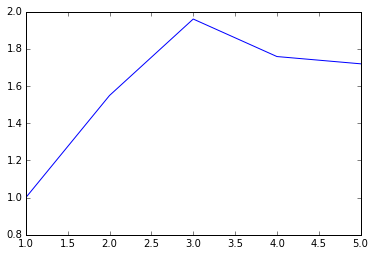

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
res = [14.7,9.49,7.5,8.36,8.55]
res = map(lambda x: 14.7/x, res)
plt.plot([1,2,3,4,5],res)

In [183]:
res

[1.0, 1.5489989462592202, 1.96, 1.7583732057416268, 1.7192982456140349]

# Checking influence of balancing

In [136]:
rus = RandomUnderSampler(return_indices=True)

In [139]:
dataset_reduced.astype(bool).sum(axis=0)

i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01    3853
i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec    2311
i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0    1905
i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6    1745
i4x://KNU/101/problem/b9daef58e5884fa8b0c36c5c9bd233ce    1529
i4x://KNU/101/problem/7fb5b2515e09416f9977f465f909a746    1410
i4x://KNU/101/problem/e663ed76dc9445dead9354a158daf163    1397
i4x://KNU/101/problem/f1fb3e3d588a4380b7226b87029c284c       0
status                                                    1313
dtype: int64

In [152]:
X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01']]
y = dataset_reduced.status
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("1 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec']]
y = dataset_reduced.status
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("2 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0']]
y = dataset_reduced.status
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("3 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6']]
y = dataset_reduced.status
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("4 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6',
                    'i4x://KNU/101/problem/b9daef58e5884fa8b0c36c5c9bd233ce']]
y = dataset_reduced.status
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("5 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

1 test. Accuracy: 0.89846 (+/- 0.03790)
2 test. Accuracy: 0.94088 (+/- 0.03059)
3 test. Accuracy: 0.96334 (+/- 0.01794)
4 test. Accuracy: 0.96648 (+/- 0.01871)
5 test. Accuracy: 0.98763 (+/- 0.00606)


In [143]:
print len(dataset_reduced['i4x://KNU/101/problem/e663ed76dc9445dead9354a158daf163'])
print len(dataset_reduced.status)

15274
15274


In [156]:
#undersampling
from imblearn.under_sampling import RandomUnderSampler

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01']]
y = dataset_reduced.status
rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("1 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec']]
y = dataset_reduced.status
rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("2 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0']]
y = dataset_reduced.status
rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("3 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6']]
y = dataset_reduced.status
rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("4 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6',
                    'i4x://KNU/101/problem/b9daef58e5884fa8b0c36c5c9bd233ce']]
y = dataset_reduced.status
rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("5 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

1 test. Accuracy: 0.90327 (+/- 0.06451)
2 test. Accuracy: 0.94593 (+/- 0.02860)
3 test. Accuracy: 0.97449 (+/- 0.01953)
4 test. Accuracy: 0.97752 (+/- 0.02253)
5 test. Accuracy: 0.98934 (+/- 0.01216)


In [159]:
#oversampling
from imblearn.over_sampling import RandomOverSampler

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01']]
y = dataset_reduced.status
rus = RandomOverSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("1 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec']]
y = dataset_reduced.status
rus = RandomOverSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("2 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0']]
y = dataset_reduced.status
rus = RandomOverSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("3 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6']]
y = dataset_reduced.status
rus = RandomOverSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("4 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                     'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6',
                    'i4x://KNU/101/problem/b9daef58e5884fa8b0c36c5c9bd233ce']]
y = dataset_reduced.status
rus = RandomOverSampler()
X, y = rus.fit_sample(X, y)
scores = cross_val_score(GaussianNB(), X, y, cv=10)
print("5 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

1 test. Accuracy: 0.90606 (+/- 0.02921)
2 test. Accuracy: 0.95061 (+/- 0.01901)
3 test. Accuracy: 0.97074 (+/- 0.01185)
4 test. Accuracy: 0.97400 (+/- 0.00999)
5 test. Accuracy: 0.98979 (+/- 0.00405)


In [179]:
#SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import EditedNearestNeighbours

samplers = [RandomUnderSampler(), RandomOverSampler(), SMOTE(kind='regular'), SMOTE(kind='borderline1'), 
            SMOTE(kind='borderline2'), SMOTE(kind='svm'), ADASYN(),TomekLinks(),OneSidedSelection(),NeighbourhoodCleaningRule(),
           CondensedNearestNeighbour(),ClusterCentroids(),NearMiss(version=1),NearMiss(version=2),NearMiss(version=3),
           AllKNN(),EditedNearestNeighbours(),EditedNearestNeighbours()]

def test_saplers(samplers):
    for sampler in samplers:
        print '==========Sampler {0} starts=========='.format(sampler)
        X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01']]
        y = dataset_reduced.status
        X, y = sampler.fit_sample(X, y)
        scores = cross_val_score(GaussianNB(), X, y,cv=10)
        print("1 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

        X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec']]
        y = dataset_reduced.status
        X, y = sampler.fit_sample(X, y)
        scores = cross_val_score(GaussianNB(), X, y,cv=10)
        print("2 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

        X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                             'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0']]
        y = dataset_reduced.status
        X, y = sampler.fit_sample(X, y)
        scores = cross_val_score(GaussianNB(), X, y,cv=10)
        print("3 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

        X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                             'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6']]
        y = dataset_reduced.status
        X, y = sampler.fit_sample(X, y)
        scores = cross_val_score(GaussianNB(), X, y,cv=10)
        print("4 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

        X = dataset_reduced[['i4x://KNU/101/problem/e39129c796754099b0974db74c5b5b01','i4x://KNU/101/problem/43dbbb5417294a0faa1c43f02473e7ec',
                             'i4x://KNU/101/problem/84d4314a7fd041f59e9219de9b4e7cd0','i4x://KNU/101/problem/7ac56261c85548fd97ae8a56e5a355f6',
                            'i4x://KNU/101/problem/b9daef58e5884fa8b0c36c5c9bd233ce']]
        y = dataset_reduced.status
        X, y = sampler.fit_sample(X, y)
        scores = cross_val_score(GaussianNB(), X, y,cv=10)
        print("5 test. Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

        print '==========Sampler finished=========='

In [185]:
class DummySampler():
    def fit_sample(selct, X, y):
        return X, y
    
samplers = [DummySampler(), RandomUnderSampler(), RandomOverSampler(), TomekLinks(),NeighbourhoodCleaningRule(),
            SMOTE(kind='regular'), SMOTE(kind='borderline1'), 
            SMOTE(kind='borderline2'), SMOTE(kind='svm'),
           NearMiss(version=3),AllKNN(),EditedNearestNeighbours(),EditedNearestNeighbours()]

test_saplers(samplers)

==========Sampler <__main__.DummySampler instance at 0x000000004647D688> starts==========
1 test. Accuracy: 0.89846 (+/- 0.03790)
2 test. Accuracy: 0.94088 (+/- 0.03059)
3 test. Accuracy: 0.96334 (+/- 0.01794)
4 test. Accuracy: 0.96648 (+/- 0.01871)
5 test. Accuracy: 0.98763 (+/- 0.00606)
==========Sampler finished==========
==========Sampler RandomUnderSampler(random_state=None, ratio='auto', replacement=True,
          return_indices=False) starts==========
1 test. Accuracy: 0.91011 (+/- 0.06098)
2 test. Accuracy: 0.95239 (+/- 0.01970)
3 test. Accuracy: 0.96611 (+/- 0.02630)
4 test. Accuracy: 0.97069 (+/- 0.02636)
5 test. Accuracy: 0.98896 (+/- 0.01098)
==========Sampler finished==========
==========Sampler RandomOverSampler(random_state=None, ratio='auto') starts==========
1 test. Accuracy: 0.90459 (+/- 0.03407)
2 test. Accuracy: 0.95183 (+/- 0.02053)
3 test. Accuracy: 0.97070 (+/- 0.00902)
4 test. Accuracy: 0.97368 (+/- 0.01008)
5 test. Accuracy: 0.98969 (+/- 0.00373)
==========Sam